# Flights Data Exploration
## by Daiki Kudo

## Preliminary Wrangling

> This document explores a dataset containing approximately 7 million records of flight data in 2008.

In [1]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import os
import timeit
import glob
pd.set_option('display.max_columns', 500)

%matplotlib inline

In [2]:
# load in the dataset into pandas dataframe
df_2008 = pd.read_csv("2008.csv", dtype={'DepTime':str, "CRSDepTime":str, "ArrTime":str, "CRSArrTime":str})

In [3]:
df=df_2008.copy()

In [4]:
df.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7009728 entries, 0 to 7009727
Data columns (total 29 columns):
Year                 7009728 non-null int64
Month                7009728 non-null int64
DayofMonth           7009728 non-null int64
DayOfWeek            7009728 non-null int64
DepTime              6873482 non-null object
CRSDepTime           7009728 non-null object
ArrTime              6858079 non-null object
CRSArrTime           7009728 non-null object
UniqueCarrier        7009728 non-null object
FlightNum            7009728 non-null int64
TailNum              6926363 non-null object
ActualElapsedTime    6855029 non-null float64
CRSElapsedTime       7008884 non-null float64
AirTime              6855029 non-null float64
ArrDelay             6855029 non-null float64
DepDelay             6873482 non-null float64
Origin               7009728 non-null object
Dest                 7009728 non-null object
Distance             7009728 non-null int64
TaxiIn               6858079 non-

> There are some points I have to take care in this data.
* Duplicated rows should be deleted.
* In this analysis, I will focus only on delay, so flight records which are canceled or diverted should be removed.(Many of these rows have null values in some "Time" columns)
* It would be more convenient if there is a column "delay_elapsed" which is a delay time calculated from "ActualElapsedTime" - "CRSElapsedTime". 

In [5]:
# delete duplicsted rows  
print(df.duplicated().sum())
df = df.drop_duplicates()

4


In [6]:
# remove rows which are cancelled or diverted, and remove unnecessary columns.
print(df["Cancelled"].value_counts())
print(df["Diverted"].value_counts())
assert df[(df.Cancelled ==1) & (df.Diverted ==1)].shape[0] == 0

df = df[(df.Cancelled==0) & (df.Diverted==0)]
print(df.Cancelled.value_counts())
print(df.Diverted.value_counts())
df = df.drop(columns=["Cancelled","Diverted","CancellationCode"])

0    6872290
1     137434
Name: Cancelled, dtype: int64
0    6992459
1      17265
Name: Diverted, dtype: int64
0    6855025
Name: Cancelled, dtype: int64
0    6855025
Name: Diverted, dtype: int64


In [7]:
#  add a column "delay_elapsed"

df["delay_elapsed"] = df.ActualElapsedTime - df.CRSElapsedTime
df.head(1)

,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,TailNum,ActualElapsedTime,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay,delay_elapsed
0,2008,1,3,4,2003,1955,2211,2225,WN,335,N712SW,128.0,150.0,116.0,-14.0,8.0,IAD,TPA,810,4.0,8.0,NaN,NaN,NaN,NaN,NaN,-22.0


In [8]:
df[(df.ArrDelay - df.DepDelay - df.delay_elapsed) < -3]

,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,TailNum,ActualElapsedTime,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay,delay_elapsed


In [9]:
# confiem that ArrDelay = DepDelay + delay_elapsed (allowing erros within 3 minutes)

assert df[ (df.ArrDelay - df.DepDelay - df.delay_elapsed < -3) | (df.ArrDelay - df.DepDelay - df.delay_elapsed > 3)].shape[0] == 0

In [10]:
# descriptive statistics for numeric variables
df.describe()

,Year,Month,DayofMonth,DayOfWeek,FlightNum,ActualElapsedTime,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Distance,TaxiIn,TaxiOut,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay,delay_elapsed
count,6855025.0,6.855025e+06,6.855025e+06,6.855025e+06,6.855025e+06,6.855025e+06,6.855025e+06,6.855025e+06,6.855025e+06,6.855025e+06,6.855025e+06,6.855025e+06,6.855025e+06,1.524733e+06,1.524733e+06,1.524733e+06,1.524733e+06,1.524733e+06,6.855025e+06
mean,2008.0,6.388527e+00,1.573825e+01,3.925802e+00,2.212508e+03,1.273224e+02,1.290778e+02,1.040186e+02,8.168445e+00,9.923839e+00,7.287436e+02,6.860149e+00,1.644369e+01,1.577205e+01,3.039035e+00,1.716462e+01,7.497444e-02,2.077101e+01,-1.755392e+00
std,0.0,3.398832e+00,8.801084e+00,1.988460e+00,1.956437e+03,7.018731e+01,6.953271e+01,6.743979e+01,3.850194e+01,3.520387e+01,5.632447e+02,4.931225e+00,1.131062e+01,4.009913e+01,1.950289e+01,3.189497e+01,1.837941e+00,3.925965e+01,1.403088e+01
min,2008.0,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.200000e+01,-1.410000e+02,0.000000e+00,-5.190000e+02,-5.340000e+02,1.100000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-1.810000e+02
25%,2008.0,3.000000e+00,8.000000e+00,2.000000e+00,6.180000e+02,7.700000e+01,8.000000e+01,5.500000e+01,-1.000000e+01,-4.000000e+00,3.260000e+02,4.000000e+00,1.000000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-9.000000e+00
50%,2008.0,6.000000e+00,1.600000e+01,4.000000e+00,1.563000e+03,1.100000e+02,1.110000e+02,8.600000e+01,-2.000000e+00,-1.000000e+00,5.810000e+02,6.000000e+00,1.400000e+01,0.000000e+00,0.000000e+00,6.000000e+00,0.000000e+00,0.000000e+00,-3.000000e+00
75%,2008.0,9.000000e+00,2.300000e+01,6.000000e+00,3.494000e+03,1.570000e+02,1.590000e+02,1.320000e+02,1.200000e+01,8.000000e+00,9.540000e+02,8.000000e+00,1.900000e+01,1.600000e+01,0.000000e+00,2.100000e+01,0.000000e+00,2.600000e+01,4.000000e+00
max,2008.0,1.200000e+01,3.100000e+01,7.000000e+00,9.741000e+03,1.379000e+03,6.600000e+02,1.350000e+03,2.461000e+03,2.467000e+03,4.962000e+03,3.080000e+02,4.290000e+02,2.436000e+03,1.352000e+03,1.357000e+03,3.920000e+02,1.316000e+03,1.034000e+03


### What is the structure of your dataset?

> Now, there are  rows of flight data in the dataset with 29 features originally.  
> Variable descriptions 
>  
Name	Description
>  
1	Year	2008  
2	Month	1-12  
3	DayofMonth	1-31  
4	DayOfWeek	1 (Monday) - 7 (Sunday)  
>  
5	DepTime	        actual departure time (local, hhmm)   
6	CRSDepTime	    scheduled departure time (local, hhmm)  
7	ArrTime	actual  arrival time (local, hhmm)    
8	CRSArrTime	    scheduled arrival time (local, hhmm)  
>  
9	UniqueCarrier	unique carrier code  
10	FlightNum	    flight number  
11	TailNum	        plane tail number  
>  
12	ActualElapsedTime	(actual)    in minutes  
13	CRSElapsedTime      (scheduled)	in minutes  
14	AirTime	in minutes 
>  
15	ArrDelay	(Difference in minutes between scheduled and actual arrival time)   
16	DepDelay	(Difference in minutes between scheduled and actual departure time. )    
>  
17	Origin	origin IATA airport code    
18	Dest	destination IATA airport code   
(Code assigned by IATA and commonly used to identify a carrier. As the same code may have been assigned to different carriers over time, the code is not always unique.)
>  
19	Distance	in miles 
>  
20	TaxiIn	taxi in time, in minutes  
21	TaxiOut	taxi out time, in minutes  
>  
22	CarrierDelay        in minutes  
23	WeatherDelay	    in minutes  
24	NASDelay	        (National Air System Delay) in minutes  
25	SecurityDelay	    in minutes  
26	LateAircraftDelay	in minutes  
>
> More details can be found [here](http://aspmhelp.faa.gov/index.php/Types_of_Delay)
* Carrier Delay  
Carrier delay is within the control of the air carrier. Examples of occurrences that may determine carrier delay are: aircraft cleaning, aircraft damage, awaiting the arrival of connecting passengers or crew, baggage, bird strike, cargo loading, catering, computer, outage-carrier equipment, crew legality (pilot or attendant rest), damage by hazardous goods, engineering inspection, fueling, handling disabled passengers, late crew, lavatory servicing, maintenance, oversales, potable water servicing, removal of unruly passenger, slow boarding or seating, stowing carry-on baggage, weight and balance delays.
* Late Arrival Delay  
Arrival delay at an airport due to the late arrival of the same aircraft at a previous airport. The ripple effect of an earlier delay at downstream airports is referred to as delay propagation.
* NAS Delay  
Delay that is within the control of the National Airspace System (NAS) may include: non-extreme weather conditions, airport operations, heavy traffic volume, air traffic control, etc. Delays that occur after Actual Gate Out are usually attributed to the NAS and are also reported through OPSNET.
* Security Delay  
Security delay is caused by evacuation of a terminal or concourse, re-boarding of aircraft because of security breach, inoperative screening equipment and/or long lines in excess of 29 minutes at screening areas.
* Weather Delay  
Weather delay is caused by extreme or hazardous weather conditions that are forecasted or manifest themselves on point of departure, enroute, or on point of arrival.

### What is/are the main feature(s) of interest in your dataset?

>  
* What causes the longer delays?

### What features in the dataset do you think will help support your investigation into your feature(s) of interest?
 
> * 2 factors of delay (***departure delay + elapsed time extension***)
 - arrival delay = ArrDelay = ArrTime - CRSArrTime
 - departure delay = DepDelay = DepTime - CRSDepTime
 - elapsed time extension = ActualElapsedTime - CRSElapsedTime  
> * Distance 
> * 5 delay factors given in the dataset  
 - WeatherDelay, NAS Delay, SecurityDelay, LateAircraftDelay  

## Univariate Exploration

> In this section, I start by looking at the distrbution of main variables.  
1. Disatance  
- AirTime
- ArrDelay
- DepDelay
- delay_elapsed

### Distance

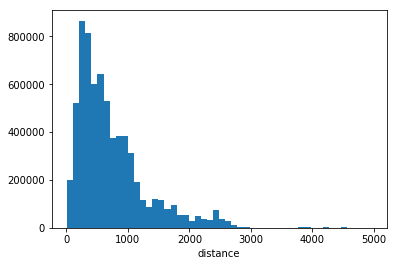

In [11]:
plt.hist(data = df, x = "Distance", bins = 50)
plt.xlabel("distance");

In [12]:
# The extremely high values  should be paid more attention. These can be outliers.
df[ df.Distance > 3500].sample(5)

,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,TailNum,ActualElapsedTime,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay,delay_elapsed
3588773,2008,6,7,6,1014,1000,1342,1333,DL,1273,N832MH,568.0,573.0,536.0,9.0,14.0,ATL,HNL,4502,4.0,28.0,NaN,NaN,NaN,NaN,NaN,-5.0
4199626,2008,7,13,7,1416,1335,1839,1810,CO,15,N67058,623.0,635.0,602.0,29.0,41.0,EWR,HNL,4962,6.0,15.0,4.0,0.0,0.0,0.0,25.0,-12.0
5682426,2008,10,30,4,1528,1530,605,612,DL,1282,N831MH,517.0,522.0,494.0,-7.0,-2.0,HNL,ATL,4502,7.0,16.0,NaN,NaN,NaN,NaN,NaN,-5.0
6896022,2008,12,29,1,1254,1250,1646,1720,AA,5,N386AA,472.0,510.0,459.0,-34.0,4.0,DFW,HNL,3784,2.0,11.0,NaN,NaN,NaN,NaN,NaN,-38.0
6152257,2008,11,23,7,1757,1757,605,549,UA,1003,N210UA,488.0,472.0,456.0,16.0,0.0,KOA,ORD,4213,15.0,17.0,0.0,0.0,16.0,0.0,0.0,16.0


In [13]:
# It seems like they are flight from or to Hawaii.  Confirm all the high values applies to them.
hawaii = ["HNL", "OGG", "KOA"]
assert df[(df.Distance > 3500) & (~df.Origin.isin(hawaii)) & (~df.Dest.isin(hawaii)) ].shape[0] == 0

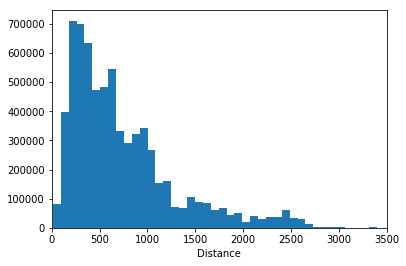

In [14]:
# take a closer look at the data in the x-range bwtween 0 and 3500.
# set x-limit betweeen 0 and 3500
plt.hist(data=df, x="Distance", bins=60)
plt.xlabel("Distance")
plt.xlim([0,3500]);

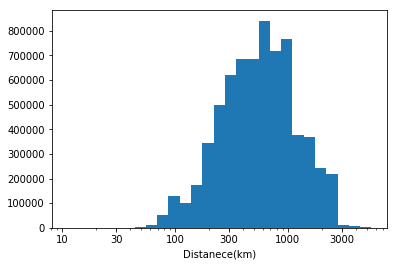

In [15]:
# There is a long tail in the distribution, so put it on a log scale instead.

bin = 10 ** np.arange(np.log10(df.Distance.min()), np.log10(df.Distance.max())+0.1, 0.1)
plt.hist(data=df, x="Distance", bins=bin)
plt.xscale("log")
plt.xlabel("Distanece(km)")
plt.xticks([10,30,100,300,1000,3000],[10,30,100,300,1000,3000]);

> Distance has a long-tailed distribution, with a lot of flights on the short distance end, and a few on the long distance end. When plotted on a log-scale, the distance distribution looks roughly normal distribution with a distance ceilings at the right foot. This is simply because the longer the distance between airports is, the more limited flights there are. And some highest values are, as I saw, the flight from or to Hawaii.

### AirTime

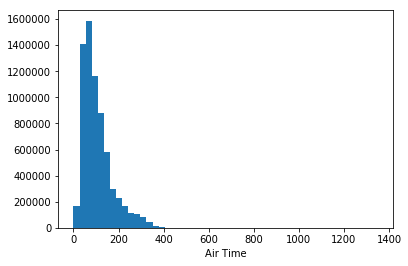

In [16]:
plt.hist(data = df, x = "AirTime", bins = 50)
plt.xlabel("Air Time");

In [17]:
# make sure that extremely high values are from the flight data which is from or to Hawaii
assert df[(df.AirTime > 600) & (~df.Origin.isin(hawaii)) & (~df.Dest.isin(hawaii))].shape[0] == 0

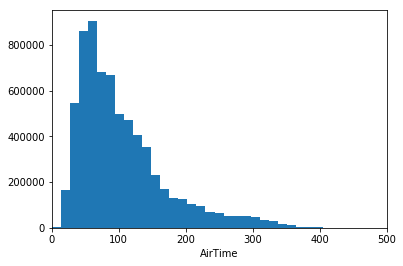

In [18]:
# Now take a closer look at the airtime distribution.
plt.hist(data = df, x = "AirTime", bins = 100)
plt.xlim([0,500])
plt.xlabel("AirTime");

> When I tried to make a log scale plot, I had ValueError and it made me realize that some of AirTime values are 0 and that I couldn't take the logarithm. I looked at these values and couldn't understand why these 0 values existed. ***This AirTime should have many things to do with Distance so I would investigate it later using bivariate visualization part.*** But now, I will remove only rows whose AirTime sre 0 to make a log plot.

In [19]:
# remove rows whose AirTime is 0.
df[df.AirTime != 0].shape[0]
df = df[df.AirTime != 0]

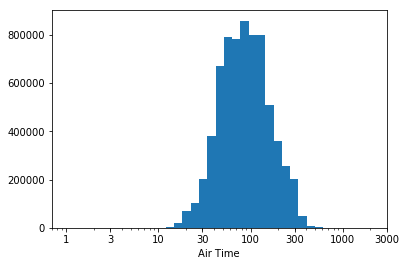

In [20]:
# There is a long right tail in the distribution, put it on a log scale instead.

bin = 10 ** np.arange(np.log10(df.AirTime.min()), np.log10(df.AirTime.max())+0.09, 0.09)
plt.hist(data=df, x="AirTime", bins=bin)
plt.xscale("log")
plt.xticks([1,3,10,30,100,300,1000,3000],[1,3,10,30,100,300,1000,3000])
plt.xlabel("Air Time");

> AirTime is right-skewed and the shape of distribution is similar to that of distance. When I tried to make a log scale plot on x-axis, I found that some values are equal to 0. I removed these rows, but I still have to check these values by comparing with Distance.

### ArrDelay

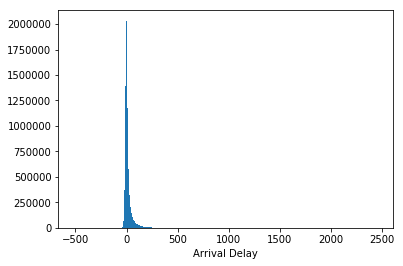

In [21]:
plt.hist(data=df, x="ArrDelay", bins=np.arange(df.ArrDelay.min(),df.ArrDelay.max()+10,10) )
plt.xlabel("Arrival Delay");

In [22]:
## The extremely high and wxtremely low values should be paid more attention. These can be outliers.
#     rows with low ArrDelay values 
df[(df.ArrDelay < -120) ]

,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,TailNum,ActualElapsedTime,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay,delay_elapsed
2486419,2008,5,8,4,1250,1300,1412,1621,XE,312,N14558,22.0,141.0,7.0,-129.0,-10.0,AUS,JAX,954,5.0,10.0,NaN,NaN,NaN,NaN,NaN,-119.0
5179806,2008,9,29,1,136,1030,456,1335,HA,7,N587HA,380.0,365.0,355.0,-519.0,-534.0,LAS,HNL,2762,5.0,20.0,NaN,NaN,NaN,NaN,NaN,15.0


In [23]:
#     rows with high ArrDelay values 
df[(df.ArrDelay > 2400) ]

,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,TailNum,ActualElapsedTime,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay,delay_elapsed
1018798,2008,2,3,7,1117,1820,2256,555,NW,808,N817NW,459.0,455.0,437.0,2461.0,2457.0,HNL,MSP,3972,6.0,16.0,1455.0,0.0,4.0,0.0,1002.0,4.0
2235378,2008,4,10,4,724,1417,858,1605,NW,1699,N3324L,154.0,168.0,132.0,2453.0,2467.0,CLT,MSP,930,8.0,14.0,2436.0,0.0,0.0,0.0,17.0,-14.0


> Even though these rows don't seem to have human errors, these arrival delays (more than 40 hours) are quite unnatural.    
I will break this arrival delay into 2 portions (DepDelay and delay_elapesd) and deal with them later.

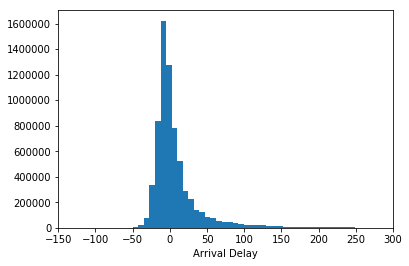

In [24]:
# take a closer look at the data ArrDelay
plt.hist(data=df, x="ArrDelay", bins=400)
plt.xlabel("Arrival Delay")
plt.xlim([-150,300]);

The distribution is a little right-skewed and the mode is around 0 minute. I have never experienced the flight which arrived earlier than scheduled, so it was surprising for me that many flight actually arrives ahead. Whether it is attributed to the earlier departure or to shorter flight time would be revealed from now.

### DepDelay

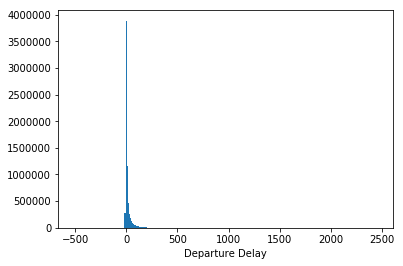

In [25]:
plt.hist(data=df, x="DepDelay",bins=np.arange(df.ArrDelay.min(),df.ArrDelay.max()+10,10))
plt.xlabel("Departure Delay");

In [26]:
df[df.DepDelay < -120]

,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,TailNum,ActualElapsedTime,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay,delay_elapsed
5179806,2008,9,29,1,136,1030,456,1335,HA,7,N587HA,380.0,365.0,355.0,-519.0,-534.0,LAS,HNL,2762,5.0,20.0,NaN,NaN,NaN,NaN,NaN,15.0


In [27]:
df[df.DepDelay > 2400]

,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,TailNum,ActualElapsedTime,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay,delay_elapsed
1018798,2008,2,3,7,1117,1820,2256,555,NW,808,N817NW,459.0,455.0,437.0,2461.0,2457.0,HNL,MSP,3972,6.0,16.0,1455.0,0.0,4.0,0.0,1002.0,4.0
2235378,2008,4,10,4,724,1417,858,1605,NW,1699,N3324L,154.0,168.0,132.0,2453.0,2467.0,CLT,MSP,930,8.0,14.0,2436.0,0.0,0.0,0.0,17.0,-14.0


> I investigated outliers for a while and decided to remove only 1 row which showed -534 minutes departure delay between Las Vegas and Hawaii, which rarely happens.  
Even though delays more than 1 day are unusual, the reasons of them are explained and so I will leave them.

In [28]:
#  remove rows with outliers in DepDelay column.
df = df[(df.DepDelay > -120)]

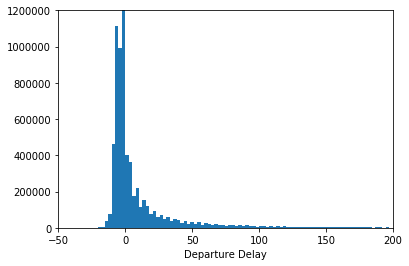

In [29]:
# plot the histgram again in the limit of [-50<x<200]
plt.hist(data=df, x="DepDelay",bins=1000)
plt.xlabel("Departure Delay")
plt.xlim([-50,200])
plt.ylim([0,1200000]);

> The distribution of the delay of departure time is right-skewed and the mode is around 0 minutes, which makes sense.

### Delay_Elapsed

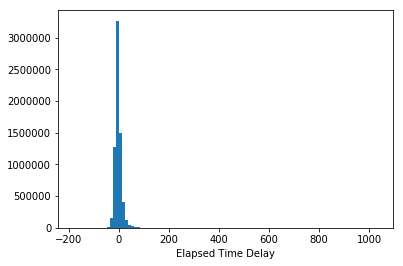

In [30]:
plt.hist(data=df, x="delay_elapsed", bins = 100)
plt.xlabel("Elapsed Time Delay");

In [31]:
df[df.delay_elapsed < -100]

,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,TailNum,ActualElapsedTime,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay,delay_elapsed
682725,2008,2,26,2,2116,1940,2130,2135,WN,1830,N747SA,134.0,235.0,125.0,-5.0,96.0,MCI,SMF,1442,4.0,5.0,NaN,NaN,NaN,NaN,NaN,-101.0
1637767,2008,3,9,7,1823,1420,2051,1910,9E,2029,91469E,148.0,290.0,90.0,101.0,243.0,PIT,ATL,526,32.0,26.0,0.0,0.0,0.0,0.0,101.0,-142.0
1705852,2008,3,8,6,1256,1135,1627,1737,AA,2093,N3CDAA,211.0,362.0,177.0,1370.0,1521.0,LGA,MIA,1097,5.0,29.0,50.0,0.0,1289.0,0.0,31.0,-151.0
2486419,2008,5,8,4,1250,1300,1412,1621,XE,312,N14558,22.0,141.0,7.0,-129.0,-10.0,AUS,JAX,954,5.0,10.0,NaN,NaN,NaN,NaN,NaN,-119.0
2558089,2008,5,1,4,1302,929,1427,1355,OO,6595,N924SW,85.0,266.0,70.0,32.0,213.0,SLC,DEN,391,6.0,9.0,32.0,0.0,0.0,0.0,0.0,-181.0
3092993,2008,6,15,7,1244,940,1519,1420,XE,408,N12563,95.0,220.0,84.0,59.0,184.0,SAN,ABQ,628,5.0,6.0,59.0,0.0,0.0,0.0,0.0,-125.0
3698229,2008,7,31,4,1449,1430,1331,1520,WN,987,N396SW,42.0,170.0,29.0,-109.0,19.0,AUS,SAN,1164,3.0,10.0,NaN,NaN,NaN,NaN,NaN,-128.0


In [32]:
df[df.delay_elapsed > 360]

,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,TailNum,ActualElapsedTime,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay,delay_elapsed
1556682,2008,3,6,4,906,905,2103,1315,HA,7,N585HA,837.0,370.0,823.0,468.0,1.0,LAS,HNL,2762,5.0,9.0,468.0,0.0,0.0,0.0,0.0,467.0
2160490,2008,4,27,7,1343,1340,748,2215,HA,22,N587HA,905.0,335.0,886.0,573.0,3.0,HNL,SEA,2677,9.0,10.0,573.0,0.0,0.0,0.0,0.0,570.0
2763487,2008,5,24,6,920,920,519,1205,HA,21,N580HA,1379.0,345.0,1350.0,1034.0,0.0,SEA,HNL,2677,16.0,13.0,1034.0,0.0,0.0,0.0,0.0,1034.0
2763567,2008,5,11,7,1228,1230,811,2105,HA,28,N583HA,1003.0,335.0,981.0,666.0,-2.0,HNL,SEA,2677,4.0,18.0,648.0,0.0,0.0,0.0,18.0,668.0
2763603,2008,5,16,5,1021,1035,303,1320,HA,29,N592HA,1182.0,345.0,1154.0,823.0,-14.0,SEA,OGG,2640,5.0,23.0,823.0,0.0,0.0,0.0,0.0,837.0
3900816,2008,7,23,3,1559,1605,20,1825,US,598,N657AW,681.0,320.0,279.0,355.0,-6.0,PHL,LAS,2176,9.0,393.0,0.0,0.0,355.0,0.0,0.0,361.0
3922427,2008,7,23,3,1727,1645,323,2033,DL,151,N6700,776.0,408.0,346.0,410.0,42.0,JFK,SFO,2586,8.0,422.0,0.0,0.0,368.0,0.0,42.0,368.0
3993887,2008,7,16,3,228,230,1250,520,HA,17,N586HA,802.0,350.0,757.0,450.0,-2.0,LAS,HNL,2762,23.0,22.0,450.0,0.0,0.0,0.0,0.0,452.0
4614554,2008,8,19,2,1547,1230,717,2105,HA,28,N597HA,750.0,335.0,733.0,612.0,197.0,HNL,SEA,2677,4.0,13.0,612.0,0.0,0.0,0.0,0.0,415.0
5180146,2008,9,9,2,1411,920,545,1215,HA,21,N586HA,1114.0,355.0,1091.0,1050.0,291.0,SEA,HNL,2677,5.0,18.0,1040.0,0.0,0.0,0.0,10.0,759.0


In [33]:
df = df[ ~(df.index.isin([2486419,3698229])) ]

> I investigated the data and decided to remove 2 rows whose indexes are 2486419 or 3698229 (both in the first cell).  
I made this decision by comparing AirTime and ActualElapsedTime. These 2 rows had extremely short AirTimes considering Distances.  
Regarding rest of them, there seems like no reason to be deleted.

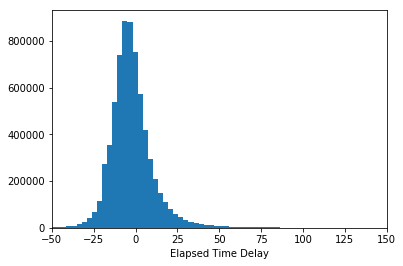

In [34]:
# plot the histgram again in the limit of [-50<x<200]
plt.hist(data=df, x="delay_elapsed",bins=400)
plt.xlabel("Elapsed Time Delay")
plt.xlim([-50,150]);

> Though departure delay was right skewed, the elapsed time delay is symmetric. The mode is less than 0 minute and it can be assumed that in-flight time is a little longer estimated.
>
> The distributions of Departure delay and Elapsed time delay account for the arrival delay. The earlier arrival are more associated with shorter flight time, and the late arrival delays may be rather due to lengthy departure delay.

### Each of 5 Delay Factors

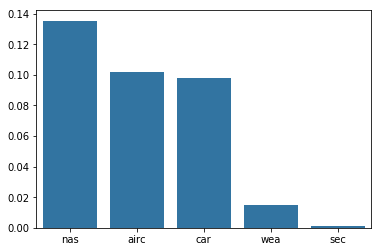

In [35]:
# The proportion where each type of delay occurs.
p_car = df[(~df.CarrierDelay.isnull()) & (df.CarrierDelay!=0)].shape[0] / df.shape[0]
p_wea = df[(~df.WeatherDelay.isnull()) & (df.WeatherDelay!=0)].shape[0] / df.shape[0]
p_nas = df[(~df.NASDelay.isnull()) & (df.NASDelay!=0)].shape[0] / df.shape[0]
p_sec = df[(~df.SecurityDelay.isnull()) & (df.SecurityDelay!=0)].shape[0] / df.shape[0]
p_airc = df[(~df.LateAircraftDelay.isnull()) & (df.LateAircraftDelay!=0)].shape[0] / df.shape[0]

delay_types = pd.Series([p_car,p_wea,p_nas,p_sec,p_airc], index=["car","wea","nas","sec","airc"]).sort_values(ascending=False)
sb.barplot(delay_types.index, delay_types, color=sb.color_palette()[0]);

> This is the probability that each type of delay occurred in 2008. (2 types of delay can simultaneously happen at the same flight!!!)  
This plot suggests that delay caused by National Airspace System (NAS) more frequently happens and surprisingly for me, delay due to bad weather or security check which I personally have thought is the main reason I can be stuck in the airport happens less frequently.

/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


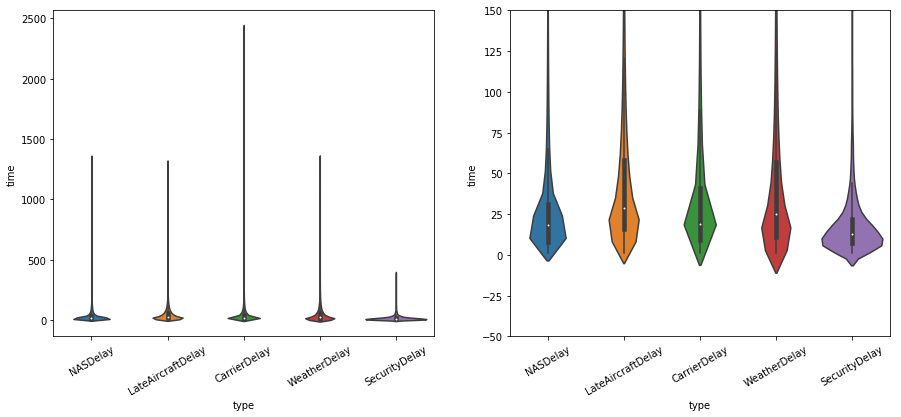

In [36]:
# take a look at the distribution on how many minutes each delay factor can prolong the flight time

## make dummy series which has 2 columns, delay type and delay time
dummy = pd.DataFrame()
delay_types = ["NASDelay","LateAircraftDelay","CarrierDelay","WeatherDelay","SecurityDelay"]

for type in delay_types:
    dum = pd.DataFrame()
    dum["time"] = df[(df[type] != 0) & (~df[type].isnull())][type]
    dum["type"] = type
    dummy = dummy.append(dum)

plt.figure(figsize=[15,6])
plt.subplot(1,2,1)
sb.violinplot(data= dummy, x="type", y="time")
plt.xticks(rotation=30);
plt.subplot(1,2,2)
sb.violinplot(data= dummy, x="type", y="time")
plt.ylim([-50,150])
plt.xticks(rotation=30);

> These distribution plots suggest that LateAirCraftDelay and WeatherDelay tend to take longer rather than NASDelay and CarrierDelay. Regarding SecurityDelay, since the length of time is shorter and also the frequency it happens is by far the least of the 5, the effect can be thought to be quite weaker than other 4 factors. From now on, ***I will investigate only 4 effects of "NASDelay", "LateAircraftDelay", "CarrierDelay", "WeatherDelay".***

### Discuss the distribution(s) of your variable(s) of interest. Were there any unusual points? Did you need to perform any transformations?

> 
>  
The distribution arrival delay was a little right-skewed and the mode is around 0 minute. It revealed that many flight actually arrives ahead of scheduled time. This could be investigated further by breaking down into 2 portions, Departure delay and Elapsed time delay. 
>  
   - The distribution of the Departure delay was right-skewed and the mode was around 0 minute.   
   - Elapsed time delay was symmetric and the mode was less than 0 minute.   

>     
I could assume that earlier arrival is more associated with shorter flight time, and the late arrival delays may be rather due to lengthy departure delay. I could not perform log transformation though they were skewed, because the range of these variables involved negative values. 
>
>
>
> I also visualized the property of 5 delay factors. The plot suggested that delay caused by National Airspace System (NAS) happened most frequently followed by LateAircraftDelay, CarrierDelay and WeatherDelay. Regarding the length of delay time, LateAirCraftDelay and WeatherDelay tend to take longer than NASDelay and CarrierDelay.   
>  
The effect of SecurityDelay was thought to be quite weaker than other 4 factors, so I decided to investigate only only 4 delay factors from now on.


### Of the features you investigated, were there any unusual distributions? Did you perform any operations on the data to tidy, adjust, or change the form of the data? If so, why did you do this?

> When investigating Distance, I found the data which showed extremely ling distances more than 3500km. I found that these records are the flight which are from or to Hawaiian airport, so I left them.  
>
> Though I removed 1 row which had extremely long AirTime just for safety, this dataset seems to be quite reliable.  

## Bivariate Exploration

> To start off with, I want to look at the pairwise correlations present between features in the data.  

In [37]:
df2 = df.copy()
numeric_vars = ["ArrDelay","delay_elapsed","DepDelay","Distance","AirTime","NASDelay","LateAircraftDelay","CarrierDelay","WeatherDelay"]
categoric_var = []

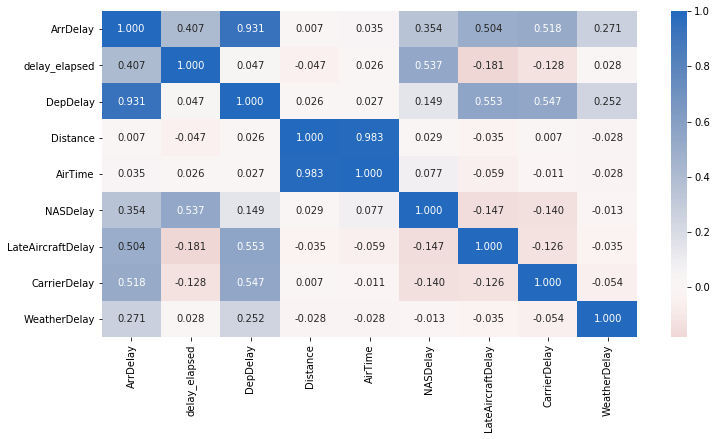

In [38]:
# correlation plot
plt.figure(figsize=[12,6])
sb.heatmap(df[numeric_vars].corr(), annot=True, fmt=".3f", cmap="vlag_r", center=0);

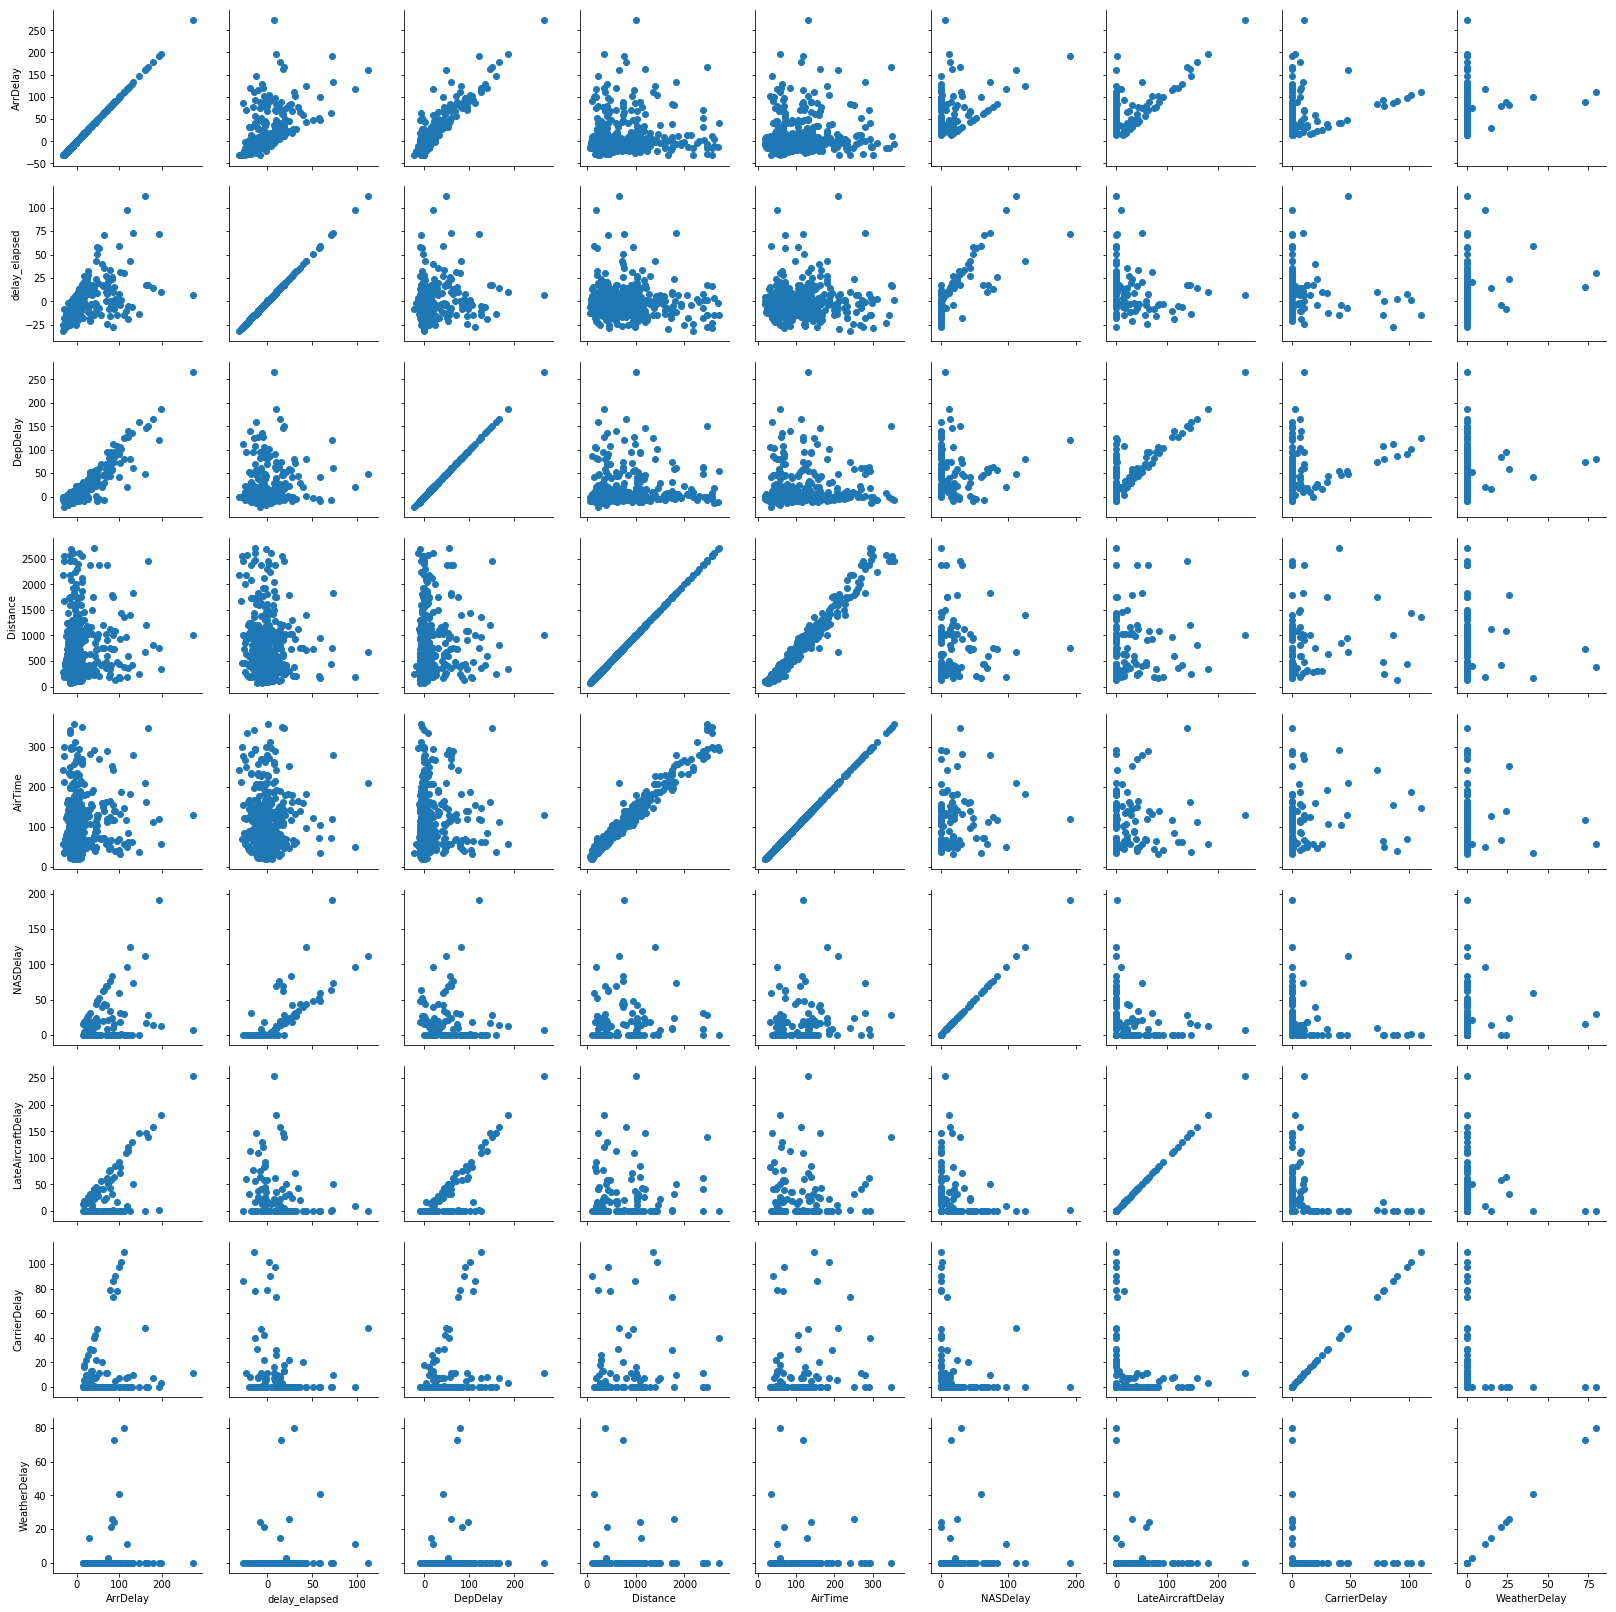

In [39]:
# plot matrix : sample 1000 flight data so that plots are clearer and they render faster
samples = np.random.choice(df2.shape[0], 500, replace=False)
df2_sample = df2.iloc[samples,:]

g = sb.PairGrid(data=df2_sample, vars=numeric_vars)
#g = g.map_diag(plt.hist, bins = 30);
g.map(plt.scatter);

> As expected, Distance and AirTime has strong positive correlationship. This is totally understandable because as the distance longer, it takes time to fly there. This will be explored in this section because as I wrote in the last section, I have to pay attention to extremely short AirTimes and clarify their reason.
>  
Also it is worth noting that the Arrival Delay time has higher correlation coefficient with Departure Delay, which suggests that arrival delay more relies on Departure delay.  
>
> The correlation coefficients between (delay_elapsed/DepDelay) vs. (each of 4 Delay Factors) are also interesting. Elapsed Time delay has by far the strongest correlationship with the factor "NAS Delay", and not with other 3 factors. This is because NAS System is highly associated with flight time.

### Distance vs. AirTime

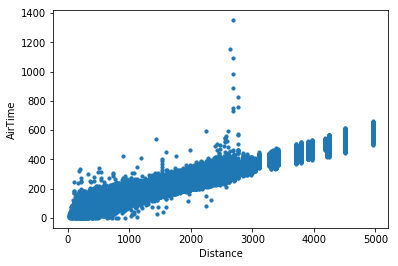

In [40]:
plt.scatter(data=df2, x="Distance", y="AirTime", s=10)
plt.xlabel("Distance") 
plt.ylabel("AirTime");

>  
There are 2 things which should be investigated further
1. AirTime around 0 but Distance is not 0
-  Extremely long AirTime at Distance around 2800

> 1. AirTime around 0 but Distance != 0

In [41]:
#First take a look at the flight data of shortest distance
df2[df2.Distance == df2.Distance.min()]

,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,TailNum,ActualElapsedTime,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay,delay_elapsed
2547298,2008,5,15,4,2037,1800,2125,1900,OH,4988,N806CA,48.0,60.0,31.0,145.0,157.0,JFK,LGA,11,10.0,7.0,145.0,0.0,0.0,0.0,0.0,-12.0
4392215,2008,8,10,7,1315,1220,1415,1320,OH,5572,N819CA,60.0,60.0,14.0,55.0,55.0,JFK,LGA,11,8.0,38.0,55.0,0.0,0.0,0.0,0.0,0.0


> It is surprising for me that there actually exists the flight between JFK and LGA, whose distance is around 11km.  
This is the shortest flight, so the flight data which takes less than 31.0 minutes are impossible, so I will delete them.  
There still can be some wrong data, but I don't go further on them.

In [42]:
#delete these outliers
print(df2[df2.AirTime < 31.0].shape[0])
df2 = df2[df2.AirTime > 31.0]

288360


> 2. Extremely long AirTime at Distance around 2800

In [43]:
df2[(df2.Distance<3000) & (df2.AirTime>600)]

,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,TailNum,ActualElapsedTime,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay,delay_elapsed
1556682,2008,3,6,4,906,905,2103,1315,HA,7,N585HA,837.0,370.0,823.0,468.0,1.0,LAS,HNL,2762,5.0,9.0,468.0,0.0,0.0,0.0,0.0,467.0
2160490,2008,4,27,7,1343,1340,748,2215,HA,22,N587HA,905.0,335.0,886.0,573.0,3.0,HNL,SEA,2677,9.0,10.0,573.0,0.0,0.0,0.0,0.0,570.0
2763487,2008,5,24,6,920,920,519,1205,HA,21,N580HA,1379.0,345.0,1350.0,1034.0,0.0,SEA,HNL,2677,16.0,13.0,1034.0,0.0,0.0,0.0,0.0,1034.0
2763567,2008,5,11,7,1228,1230,811,2105,HA,28,N583HA,1003.0,335.0,981.0,666.0,-2.0,HNL,SEA,2677,4.0,18.0,648.0,0.0,0.0,0.0,18.0,668.0
2763603,2008,5,16,5,1021,1035,303,1320,HA,29,N592HA,1182.0,345.0,1154.0,823.0,-14.0,SEA,OGG,2640,5.0,23.0,823.0,0.0,0.0,0.0,0.0,837.0
3993887,2008,7,16,3,228,230,1250,520,HA,17,N586HA,802.0,350.0,757.0,450.0,-2.0,LAS,HNL,2762,23.0,22.0,450.0,0.0,0.0,0.0,0.0,452.0
4614554,2008,8,19,2,1547,1230,717,2105,HA,28,N597HA,750.0,335.0,733.0,612.0,197.0,HNL,SEA,2677,4.0,13.0,612.0,0.0,0.0,0.0,0.0,415.0
5180146,2008,9,9,2,1411,920,545,1215,HA,21,N586HA,1114.0,355.0,1091.0,1050.0,291.0,SEA,HNL,2677,5.0,18.0,1040.0,0.0,0.0,0.0,10.0,759.0
5180166,2008,9,29,1,920,920,1912,1215,HA,21,N586HA,772.0,355.0,753.0,417.0,0.0,SEA,HNL,2677,6.0,13.0,417.0,0.0,0.0,0.0,0.0,417.0


They are all from or to Hawaii. Now ***I decide to delete all the flight data from or to Hawaii***, because the most of outliers which I have seen so far are from Hawaii and also because these flight are not operated so much.

In [44]:
# delete all the flight data from or to Hawaii
df2[(df2.Origin.isin(hawaii)) | (df2.Dest.isin(hawaii))].shape[0]
df2 = df2[(df2.Origin.isin(hawaii)) | (df2.Dest.isin(hawaii)) == 0]

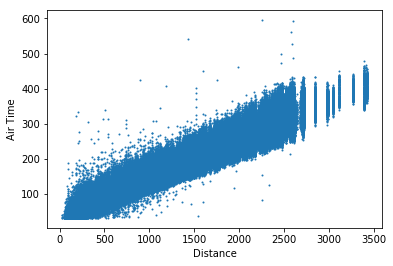

In [45]:
plt.scatter(data=df2, x="Distance", y="AirTime",s=1)
plt.xlabel("Distance")
plt.ylabel("Air Time");

> Now I can find the linear relationship between Distance and AirTime more clearly.

### DepDelay vs. ElapsedTimeDelay   /   DepDelay vs. ArrDelay   /   ElapsedTimeDelay vs. ArrDelay

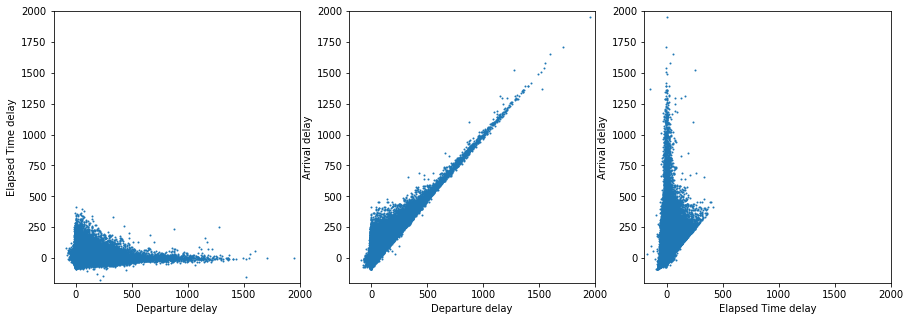

In [46]:
plt.figure(figsize=[15,5])

plt.subplot(1,3,1)
plt.scatter(data=df2, x="DepDelay", y="delay_elapsed", s=1)
plt.xlabel("Departure delay")
plt.ylabel("Elapsed Time delay");
plt.xlim([-200,2000])
plt.ylim([-200,2000]);

plt.subplot(1,3,2)
plt.scatter(data=df2, x="DepDelay", y="ArrDelay", s=1)
plt.xlabel("Departure delay")
plt.ylabel("Arrival delay")
plt.xlim([-200,2000])
plt.ylim([-200,2000]);

plt.subplot(1,3,3)
plt.scatter(data=df2, x="delay_elapsed", y="ArrDelay", s=1)
plt.xlabel("Elapsed Time delay")
plt.ylabel("Arrival delay")
plt.xlim([-200,2000])
plt.ylim([-200,2000]);

> The plot on the left reveals that Departure Delay tends to be quite longer than Elapsed time delay.  
The second and third plots support this idea.   
Even though in the plot on the right, the ArrDelay increases as the elapsed time gets longer, this tendency is limited because Elapsed TIme Delay is in the range of ElapsedTimeDelay < 500.

### Distance vs. ArrDelay   /   Distance vs. DepDelay   /   Distance vs. ElapsedTimeDelay

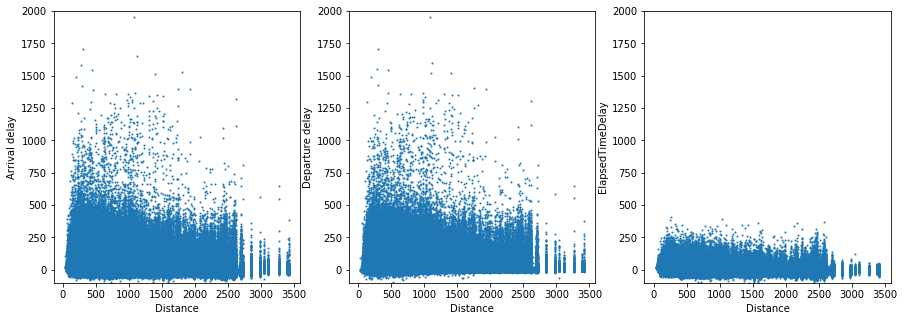

In [47]:
plt.figure(figsize=[15,5])

plt.subplot(1,3,1)
plt.scatter(data=df2, x="Distance", y="ArrDelay", s=1)
plt.xlabel("Distance")
plt.ylabel("Arrival delay")
plt.ylim([-100,2000]);

plt.subplot(1,3,2)
plt.scatter(data=df2, x="Distance", y="DepDelay", s=1)
plt.xlabel("Distance")
plt.ylabel("Departure delay")
plt.ylim([-100,2000]);

plt.subplot(1,3,3)
plt.scatter(data=df2, x="Distance", y="delay_elapsed", s=1)
plt.xlabel("Distance")
plt.ylabel("ElapsedTimeDelay")
plt.ylim([-100,2000]);

> Surprisingly, both Departure delay and Elapsed time delay are not depend on the distance between airports.  
As was found in the last step, I can find that Departure Delay can sometimes be quite long rather than Elapsed time delay.
> 
> I will make the dataframe whose each row represents each delay type of each flight. (not including delay = 0)

In [48]:
# make dummy dataframe which has 4 columns, delay type, delay time, DepDelay, delay_elapsed
dummy2 = pd.DataFrame()
delay_types = ["NASDelay","LateAircraftDelay","CarrierDelay","WeatherDelay"]

for type in delay_types:
    dum = pd.DataFrame()
    dum["time"] = df2[(df2[type] != 0) & (~df2[type].isnull())][type]
    dum["DepDelay"] = df2[(df2[type] != 0) & (~df2[type].isnull())]["DepDelay"]
    dum["delay_elapsed"] = df2[(df2[type] != 0) & (~df2[type].isnull())]["delay_elapsed"]
    dum["ArrDelay"] = df2[(df2[type] != 0) & (~df2[type].isnull())]["ArrDelay"]
    dum["Distance"] = df2[(df2[type] != 0) & (~df2[type].isnull())]["Distance"]
    dum["type"] = type
    dummy2 = dummy2.append(dum)

### Distance vs. Each-4DelayFactors 

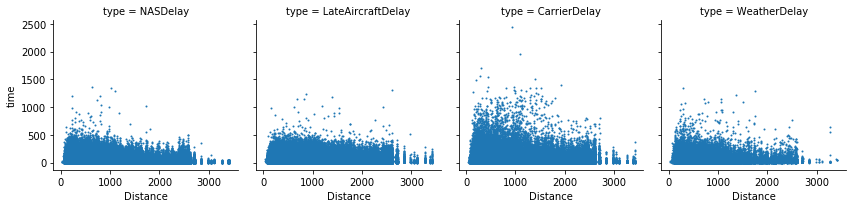

In [49]:
g = sb.FacetGrid(data=dummy2, col="type")
g.map(plt.scatter, "Distance", "time", s=1);

> Even if I break the delay time down into each type of delay, the distance seems to be not the big factor for delay time. 

### ArrTime vs. Each-4DelayFactors / DepTime vs. Each-4DelayFactors  / ElapsedTimeDelay vs. Each-4DelayFactors
> In this part, I investigate how much 5 delay factors are associated with ArrDelay / DepDelay / ElapsedTimeDelay. 

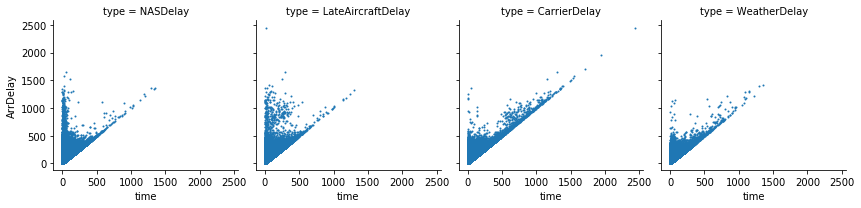

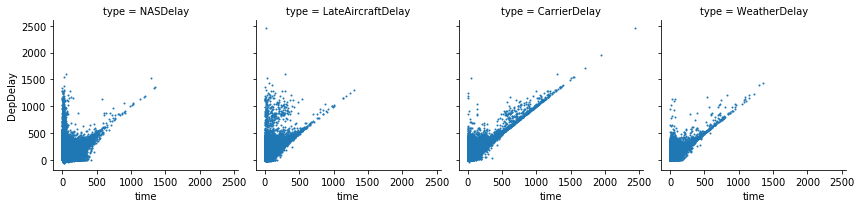

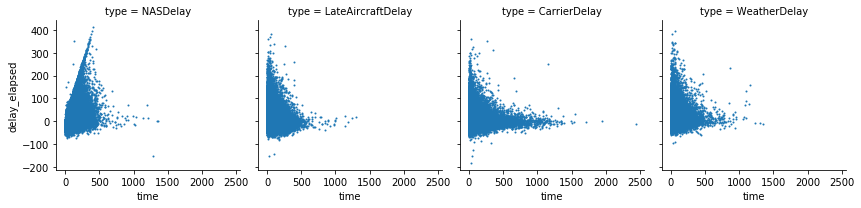

In [50]:
#plt.figure(figsize=[15,15])

#plt.subplot(3,1,1)
g = sb.FacetGrid(data=dummy2, col="type")
g.map(plt.scatter, "time", "ArrDelay", s=1);

#plt.subplot(3,1,2)
g = sb.FacetGrid(data=dummy2, col="type")
g.map(plt.scatter, "time", "DepDelay", s=1);

#plt.subplot(3,1,3)
g = sb.FacetGrid(data=dummy2, col="type")
g.map(plt.scatter, "time", "delay_elapsed", s=1);

> The most notable feature in these plots is in the plot of **NASdelay x ElapsedTimeDelay**. Even though other scatterplots in this row suggests that these delay time does not prolong the time in the flight substantially, NAS delay does.  **I would investigate the realtionship between ElapsedTimeDelay and NSA Delay in the multivariate-part linked with the flight distance.** 

### Talk about some of the relationships you observed in this part of the investigation. How did the feature(s) of interest vary with other features in the dataset?
> The first finding which was surprising for me was that Distance does not strongly affect the delay time. This is true for both DepartureDelay and ElapsedTimeDelay.  

> Another notable reltionship was found in NASdelay x ElapsedTimeDelay. Even though other delay factors did not prolong the in-flight time substantially, NAS delay did. I would investigate the realtionship between ElapsedTimeDelay and NSA Delay in the multivariate-part linking them with the flight distance.

### Did you observe any interesting relationships between the other features (not the main feature(s) of interest)?
> As was easily expected, AirTime had a linear relationship with Distance. This relationship was used to identify the impossibly short flight time. In this process, I found some outliers and noticed that they were all in the flight data from or to Hawaiian airport. So, I decide to delete all the flight data from or to Hawaii, because the most of outliers which I have seen so far are from Hawaii and also because these flight are not operated so much.

## Multivariate Exploration

> This part includes some dead-end exploration. 

In [51]:
# copy the dataframe
df3 = df2.copy()

In [52]:
# make dummy dataframe which has 5 columns, delay type, delay time, DepDelay, delay_elapsed, distance

dummy3 = pd.DataFrame()
delay_types = ["NASDelay","LateAircraftDelay","CarrierDelay","WeatherDelay"]

for type in delay_types:
    dum = pd.DataFrame()
    dum["time"] = df3[(df3[type] != 0) & (~df3[type].isnull())][type]
    dum["DepDelay"] = df3[(df3[type] != 0) & (~df3[type].isnull())]["DepDelay"]
    dum["delay_elapsed"] = df3[(df3[type] != 0) & (~df3[type].isnull())]["delay_elapsed"]
    dum["ArrDelay"] = df3[(df3[type] != 0) & (~df3[type].isnull())]["ArrDelay"]
    dum["Distance"] = df3[(df3[type] != 0) & (~df3[type].isnull())]["Distance"]
    dum["type"] = type
    dummy3 = dummy3.append(dum)

### 181104 07:00 DIstance vs. DepDelay vs. ElapsedTimeDelay 
## (Dead-End)
> In this section, I try to compare the relationship between Distance and DepDelay and that of Distance and ElapsedTimeDelay in the line plot.

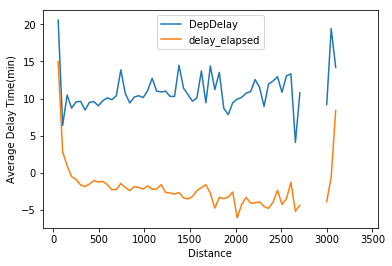

In [53]:
# Line plots of means
for de in ["DepDelay","delay_elapsed"]:
    bin_edges = np.linspace(df3.Distance.min(), df3.Distance.max(), 70)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    data_bins = pd.cut(df3.Distance, bin_edges, right = False, include_lowest=True)
    means = df3[de].groupby(data_bins).mean()
    plt.errorbar(x=bin_centers,y=means)
plt.xlabel("Distance")
plt.ylabel("Average Delay Time(min)")
plt.legend();

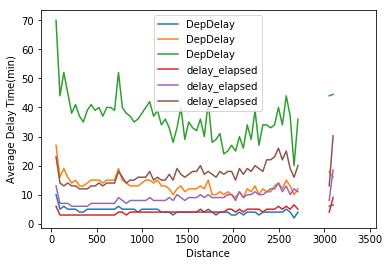

In [54]:
# Line plots of Q1~3 
df3_delay = df3[df3.delay_elapsed > 0]

for de in ["DepDelay","delay_elapsed"]:
    df3_delay = df3[df3[de] > 0]
    bin_edges = np.linspace(df3_delay.Distance.min(), df3_delay.Distance.max(), 80)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    data_bins = pd.cut(df3_delay.Distance, bin_edges, right = False, include_lowest=True)
    q1 = df3_delay[de].groupby(data_bins).quantile(.25)
    m2 = df3_delay[de].groupby(data_bins).median()
    q3 = df3_delay[de].groupby(data_bins).quantile(.75)
    plt.errorbar(x=bin_centers,y=q1)
    plt.errorbar(x=bin_centers,y=m2)
    plt.errorbar(x=bin_centers,y=q3)
plt.xlabel("Distance")
plt.ylabel("Average Delay Time(min)")
plt.legend();

> These graph are not worth using. All features found here has already been revealed in the bivariate part.

### 181105 01:00 Blocked by ElapsedTimeDelay
# (Finding1) The longer elapsed time is, the longer NASdelay is.

> In this part, I will divide the flight data into 2 blockings according to the length of ElapsedDelayTime. Then I will visualize how many minutes of delay each factor takes depending on Distance in each blocking. 

> The first column is about NAS delay. It tells that the flight data whose elapsed time took between 200 and 400 minutes are more associated with longer NASdelay time. I will make boxplot and violinplot to visualize this feature more clearly.

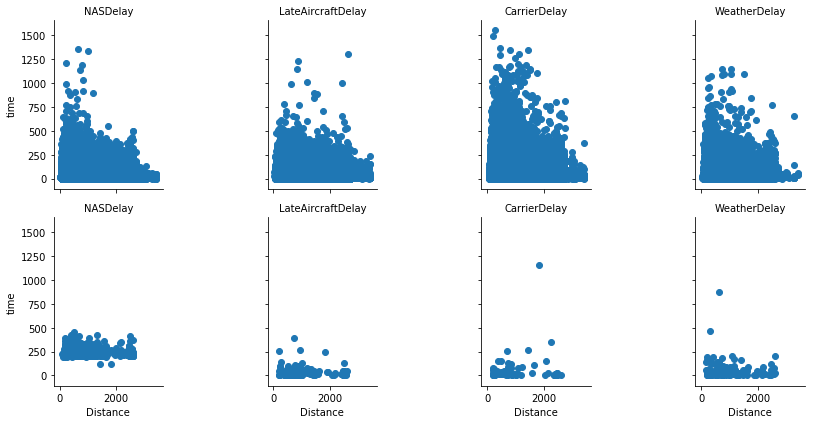

In [55]:
bin_edges = np.arange(0,600,200)
dummy3["elapsed_blocked"] = pd.cut(dummy3.delay_elapsed, bin_edges, right=False, include_lowest=True)
g = sb.FacetGrid(data=dummy3, row="elapsed_blocked", col="type" )
g.map(plt.scatter, "Distance", "time")
g.set_titles('{col_name}');

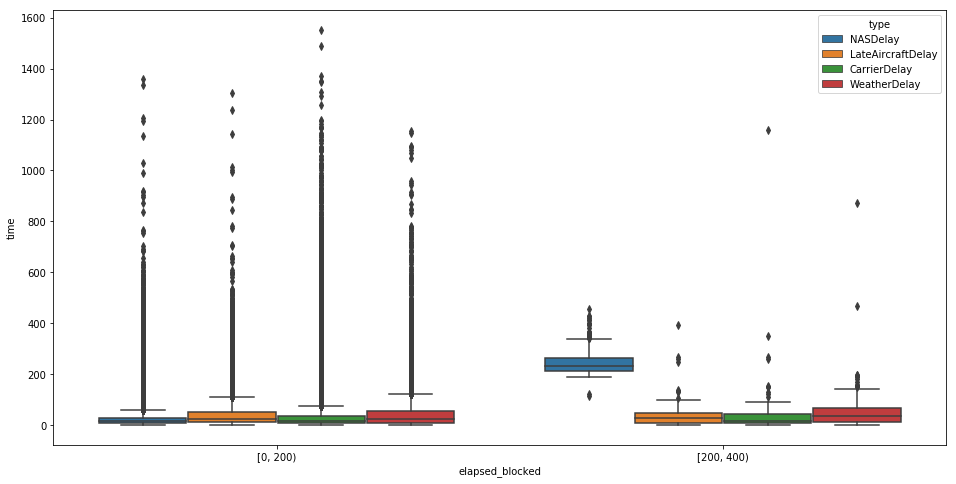

In [56]:
plt.figure(figsize=[16,8])
sb.boxplot(data=dummy3, hue="type", y="time", x="elapsed_blocked");

/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


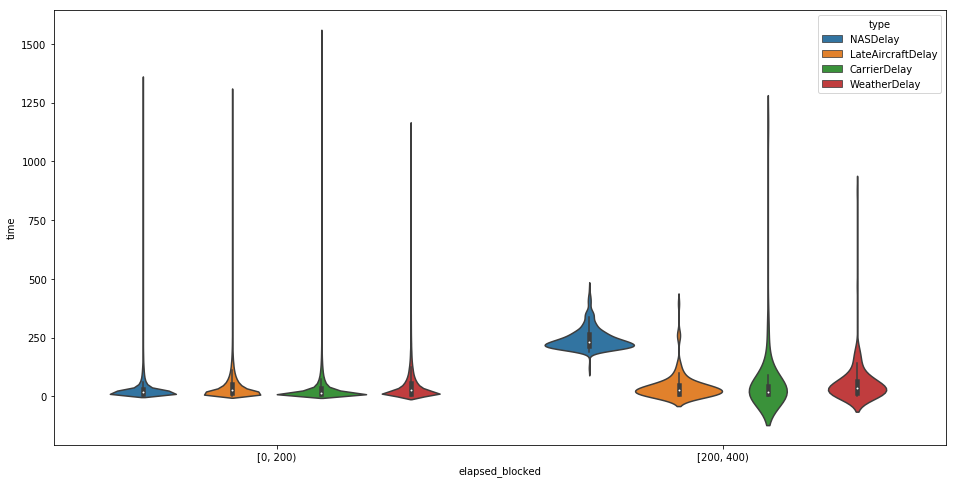

In [57]:
plt.figure(figsize=[16,8])
sb.violinplot(data=dummy3, hue="type", y="time", x="elapsed_blocked");

/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


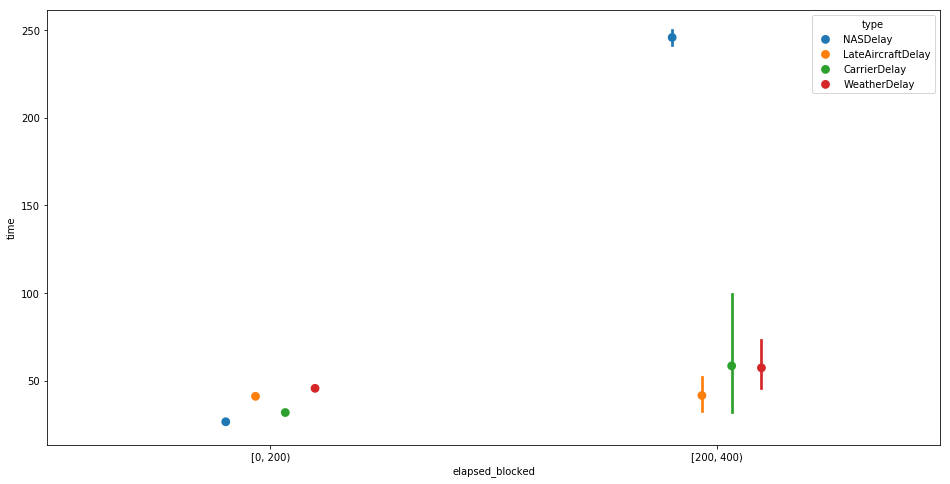

In [58]:
plt.figure(figsize=[16,8])
sb.pointplot(data=dummy3, hue="type", y="time", x="elapsed_blocked", linestyles="", dodge=0.2);

> This violinplot visualizes the trend better.

### 181105 11:00 Blocked by DepDelay
# (Finding2) The longer DepDelay is, the longer CarrierDelay is. 

> In this part, I will divide the flight data into 4 blockings according to the length of DepartureDelay. Then I will visualize how many minutes of delay each factor takes depending on Distance in each blocking just like the last part. 

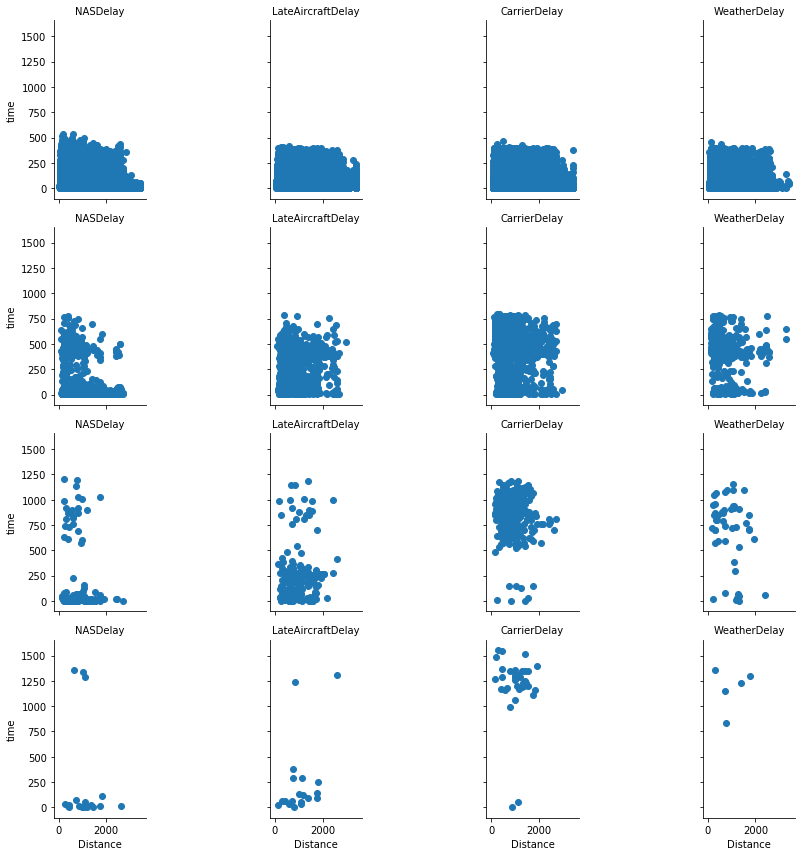

In [59]:
bin_edges = np.arange(0,2000,400)
dummy3["depdelay_blocked"] = pd.cut(dummy3.DepDelay, bin_edges, right=False, include_lowest=True)
g = sb.FacetGrid(data=dummy3, row="depdelay_blocked", col="type" )
g.map(plt.scatter, "Distance", "time")
g.set_titles('{col_name}');

In [60]:
dummy3["distance_block"] = pd.cut(dummy3.Distance, bin_edges, right=False, include_lowest=True)

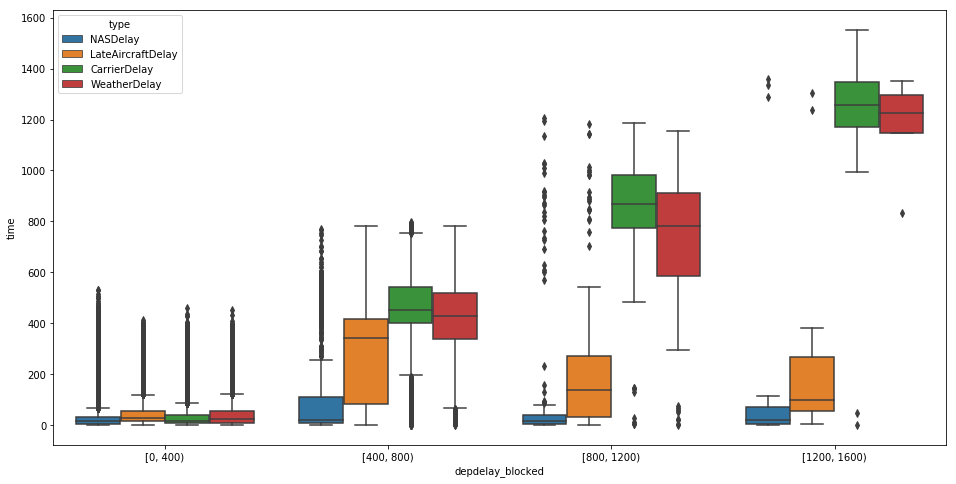

In [61]:
plt.figure(figsize=[16,8])
sb.boxplot(data=dummy3, hue="type", y="time", x="depdelay_blocked");

/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


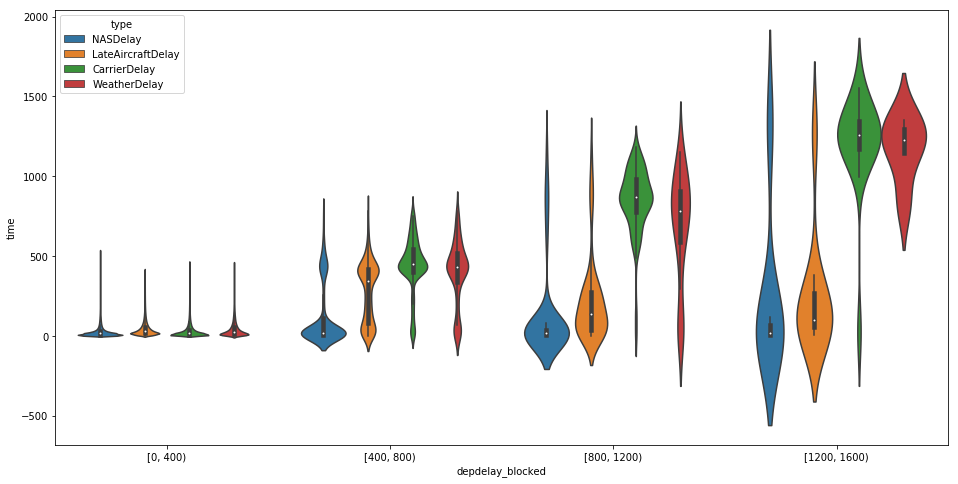

In [62]:
plt.figure(figsize=[16,8])
sb.violinplot(data=dummy3, hue="type", y="time", x="depdelay_blocked");

/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


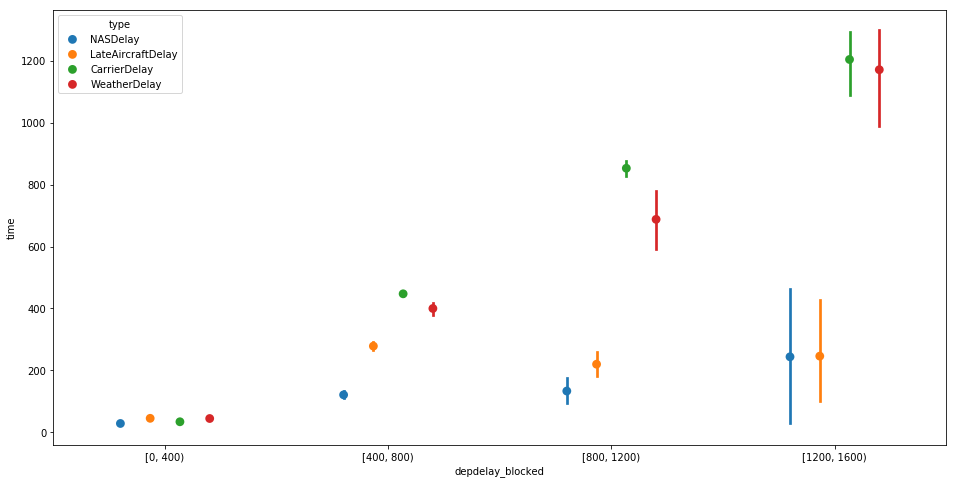

In [63]:
plt.figure(figsize=[16,8])
sb.pointplot(data=dummy3, hue="type", y="time", x="depdelay_blocked", linestyles="", dodge=0.4);

> This violinplot reveals that NASdelay and LateAir..delay have the different tendency from CarrierDelay and WeatherDelaay.  
>  
For CarrierDelay and WeatherDelay, as the longer Deparure delay time took, the more they are associated with with longer delay time.  
However, CarrierDelay and LateAir..delay do not have such tendencies.

### 1811104 15:00 Blocked by Distance

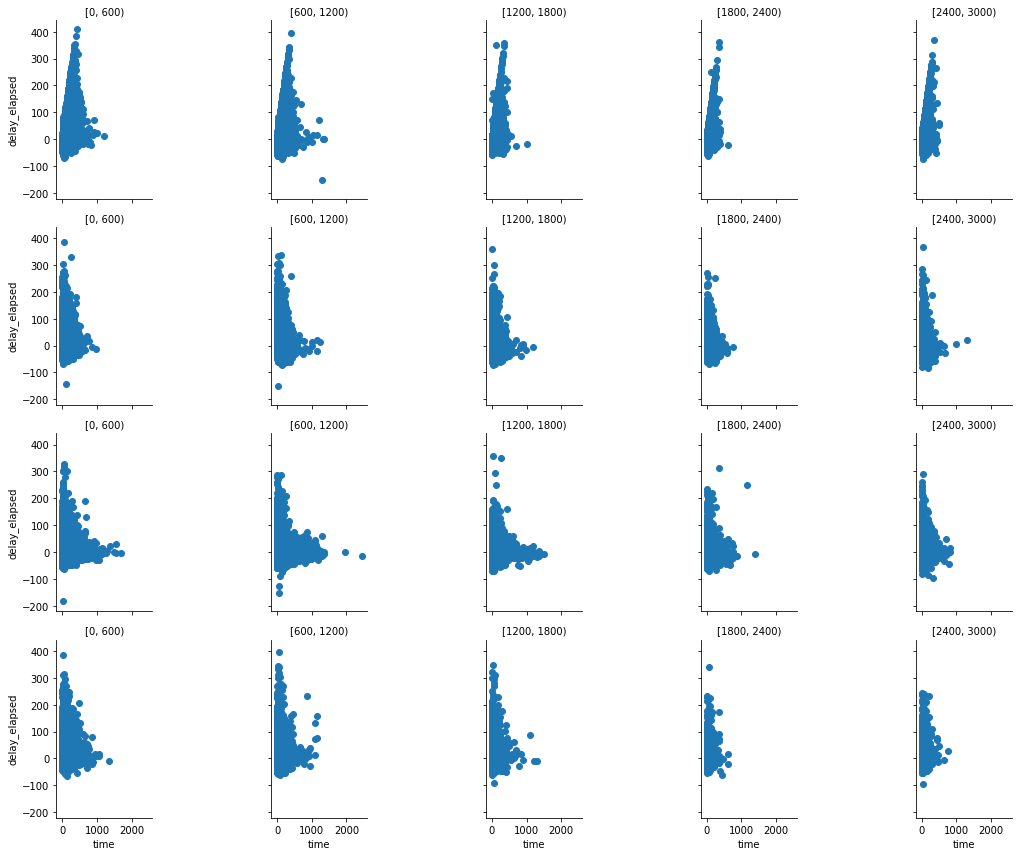

In [64]:
bin_edges = np.arange(0,3600,600)
dummy3["distance_block"] = pd.cut(dummy3.Distance, bin_edges, right=False, include_lowest=True)
g = sb.FacetGrid(data=dummy3, col="distance_block", row="type")
g.map(plt.scatter, "time", "delay_elapsed")
g.set_titles('{col_name}');

### Talk about some of the relationships you observed in this part of the investigation. Were there features that strengthened each other in terms of looking at your feature(s) of interest?

> I extended my investigation on each of DepartureDelay and ElapsedTimeDelay by looking at the impact of 4 delay factors. In this process, I found that the Distance does not have a big effect on the delay time, so I decided to stop paying attention to them.  
> 
> The multivariate exploration here showed that the flight data whose elapsed time took between 200 and 400 minutes are more associated with longer NASdelay time. When I focused on the ElapsedTimeDelay, it was shown that as the longer Departure delay time took, the more they are associated with with longer CarrierDelay and WeatherDelay.

### Were there any interesting or surprising interactions between features?

> As I paid attention in the last section, long ElapsedTimeDelay was associated with long NASdelay. This makes sense when I look back the definition of NASdelay.  
>  
What was interesting for me was that when I focused on CarrierDelay and WeatherDelay, even though their occurrence were lower than other 2 factors, they are more highly associated with long DepartureDelay.